# Iterative Construction of a Penalised Vine Structure
This notebook iteratively estimate the quantile.

#### Libraries

In [1]:
import openturns as ot
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

%load_ext autoreload
%autoreload 2

random_state = 123
np.random.seed(random_state)

#### Model function
This example consider the simple additive example.

In [2]:
from dependence.tests import func_overflow, margins_overflow, var_names_overflow, func_sum

test_func = func_overflow

#### Dimension and margins
We first define the problem dimension and the margins

In [3]:
margins = margins_overflow
dim = len(margins)

We chose the coefficients of the variables throught the additive function.

#### Copula families
We now consider only Gaussian dependencies for this example

In [4]:
families = np.zeros((dim, dim), dtype=int)
for i in range(1, dim):
    for j in range(i):
        families[i, j] = 1

## Estimations
We create an instance of the main class for conservative estimate, and we define a q_func object for the quantile as a quantity of interest

In [5]:
from dependence import ConservativeEstimate, quantile_func

alpha = 0.95

if alpha > 0.5: # Maximizing the quantile
    def q_func(x, axis=1):
        return - quantile_func(alpha)(x, axis=axis)
else: # Minimizing
    q_func = quantile_func(alpha)

quant_estimate = ConservativeEstimate(model_func=test_func, margins=margins, families=families)

First, we compute the quantile at independence

In [6]:
n = 10000
indep_result = quant_estimate.independence(n_input_sample=n, q_func=q_func, random_state=random_state)

In [9]:
indep_result.compute_bootstrap(1000)
boot_std = indep_result.bootstrap_sample.std()
boot_mean = indep_result.bootstrap_sample.mean()
print('Quantile at independence: %.2f with a C.O.V at %.1f %%' % (boot_mean, abs(boot_std/boot_mean)*100.))

Quantile at independence: 4.86 with a C.O.V at 2.1 %


In [52]:
import pandas as pd

In [180]:
n = 10000
K = 20

from dependence.utils import get_grid_sample, to_copula_params

families[1, 0] = 1
quant_estimate.families = families
kendalls = np.asarray(get_grid_sample(quant_estimate._bounds_tau_list, K, 'lhs'))
converter = [quant_estimate._copula_converters[k] for k in quant_estimate._pair_ids]
params = to_copula_params(converter, kendalls)
output_sample = quant_estimate.run_stochastic_models(params, n, return_input_sample=False)[0]

In [181]:
df = pd.DataFrame(np.asarray(output_sample).T)
df.columns = kendalls.ravel().tolist()
df = df.stack().to_frame('Normal')
df.reset_index(inplace=True, level=1)
df.columns = ['kendalls', 'Quantile']

In [186]:
df

,kendalls,Normal
0,-0.7425,-12.369825
0,0.3465,-11.933247
0,-0.3465,-9.986879
0,0.7425,-7.923533
0,-0.5445,-10.545214
0,-0.8415,-10.341002
0,-0.4455,-2.911347
0,-0.9405,-10.409443
0,0.0495,-7.163366
0,0.9405,-10.879820


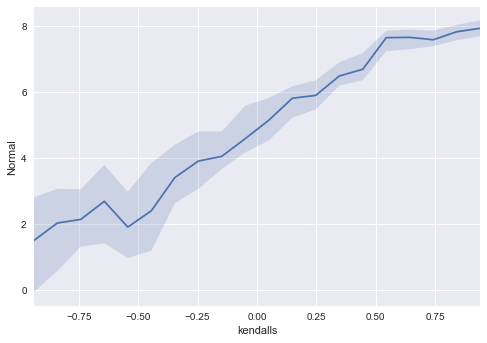

In [187]:
sns.tsplot(data=df, time='kendalls', ci=[99], estimator=q_func, value='Quantile')

In [29]:



copulas = ['Normal', 'Clayton', 'Gumbel']
copula_num = {'Normal': 1,
             'Clayton': 3,
             'Gumbel': 4}
output_samples = {}
kendalls = {}
for copula in copulas:
    families = np.zeros((dim, dim), dtype=int)
    families[1, 0] = copula_num[copula]
    quant_estimate.families = families
    converter = [quant_estimate._copula_converters[k] for k in quant_estimate._pair_ids]
    params = to_copula_params(converter, kendalls)
    output_sample[copula] = quant_estimate.run_stochastic_models(params, n, return_input_sample=False)[0]
    output_samples[copula] = np.asarray(result.output_samples).T
    kendalls[copula] = result.kendalls

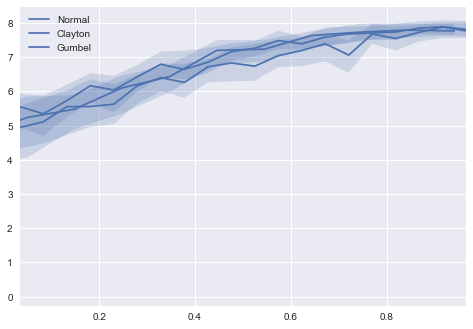

In [30]:
import seaborn as sns
for copula in copulas:
    sns.tsplot(output_samples[copula], time=kendalls[copula], ci=[99], estimator=q_func, condition=copula)

### Iterative Approach
Now lets see how good we can be with the iterative appraoch.

In [42]:
algorithm_parameters = {
    "n_input_sample": 10000,
    "n_dep_param_init": 10,
    "max_n_pairs": 3,
    "grid_type": 'vertices',
    "q_func": q_func,
    "n_add_pairs": 2,
    "n_remove_pairs": 5,
    "adapt_vine_structure": True,
    "with_bootstrap": False,
    "verbose": True,
    "iterative_save": False,
    "iterative_load": False,
    "load_input_samples": False,
    "keep_input_samples": False,
    "input_names": var_names_overflow
}

quant_estimate = ConservativeEstimate(model_func=test_func, margins=margins, families=families)

iterative_results = iterative_vine_minimize(estimate_object=quant_estimate, **algorithm_parameters)

n=10000. Worst quantile of [(1, 0)] at 1.9239664002968615
The variables are: K_s-Q
n=10000. Worst quantile of [(2, 0)] at 3.899128727649981
The variables are: Z_v-Q
n=10000. Worst quantile of [(2, 1)] at 4.2901208061154135
The variables are: Z_v-K_s
n=10000. Worst quantile of [(3, 0)] at 4.579129835364795
The variables are: Z_m-Q
n=10000. Worst quantile of [(3, 1)] at 4.603988597891442
The variables are: Z_m-K_s
n=10000. Worst quantile of [(3, 2)] at 4.718649546966153
The variables are: Z_m-Z_v
n=10000. Worst quantile of [(4, 0)] at 4.2408986431943
The variables are: H_d-Q
n=10000. Worst quantile of [(4, 1)] at 4.564189709680371
The variables are: H_d-K_s
n=10000. Worst quantile of [(4, 2)] at 4.9241430425079455
The variables are: H_d-Z_v
n=10000. Worst quantile of [(4, 3)] at 4.917486528598701
The variables are: H_d-Z_m
n=10000. Worst quantile of [(5, 0)] at 4.5933890335671705
The variables are: C_b-Q
n=10000. Worst quantile of [(5, 1)] at 4.748664916715081
The variables are: C_b-K_s


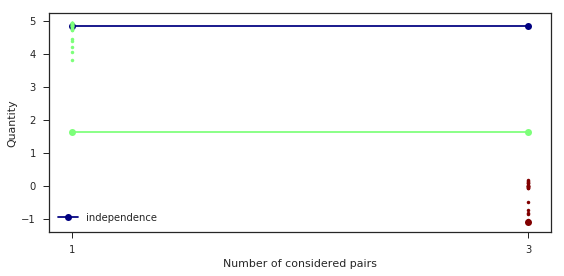

In [10]:
from dependence.dependence_plot import plot_iterative_results, matrix_plot_input

plot_iterative_results(iterative_results, indep_result=indep_result, q_func=q_func)

In [43]:
n = 10000
K = 200
quant_estimate.vine_structure = None
grid_results = quant_estimate.gridsearch(n_dep_param=K, n_input_sample=n, q_func=q_func)

In [44]:
min_result = grid_results.min_result
print(min_result.quantity)

-0.8505968697014238


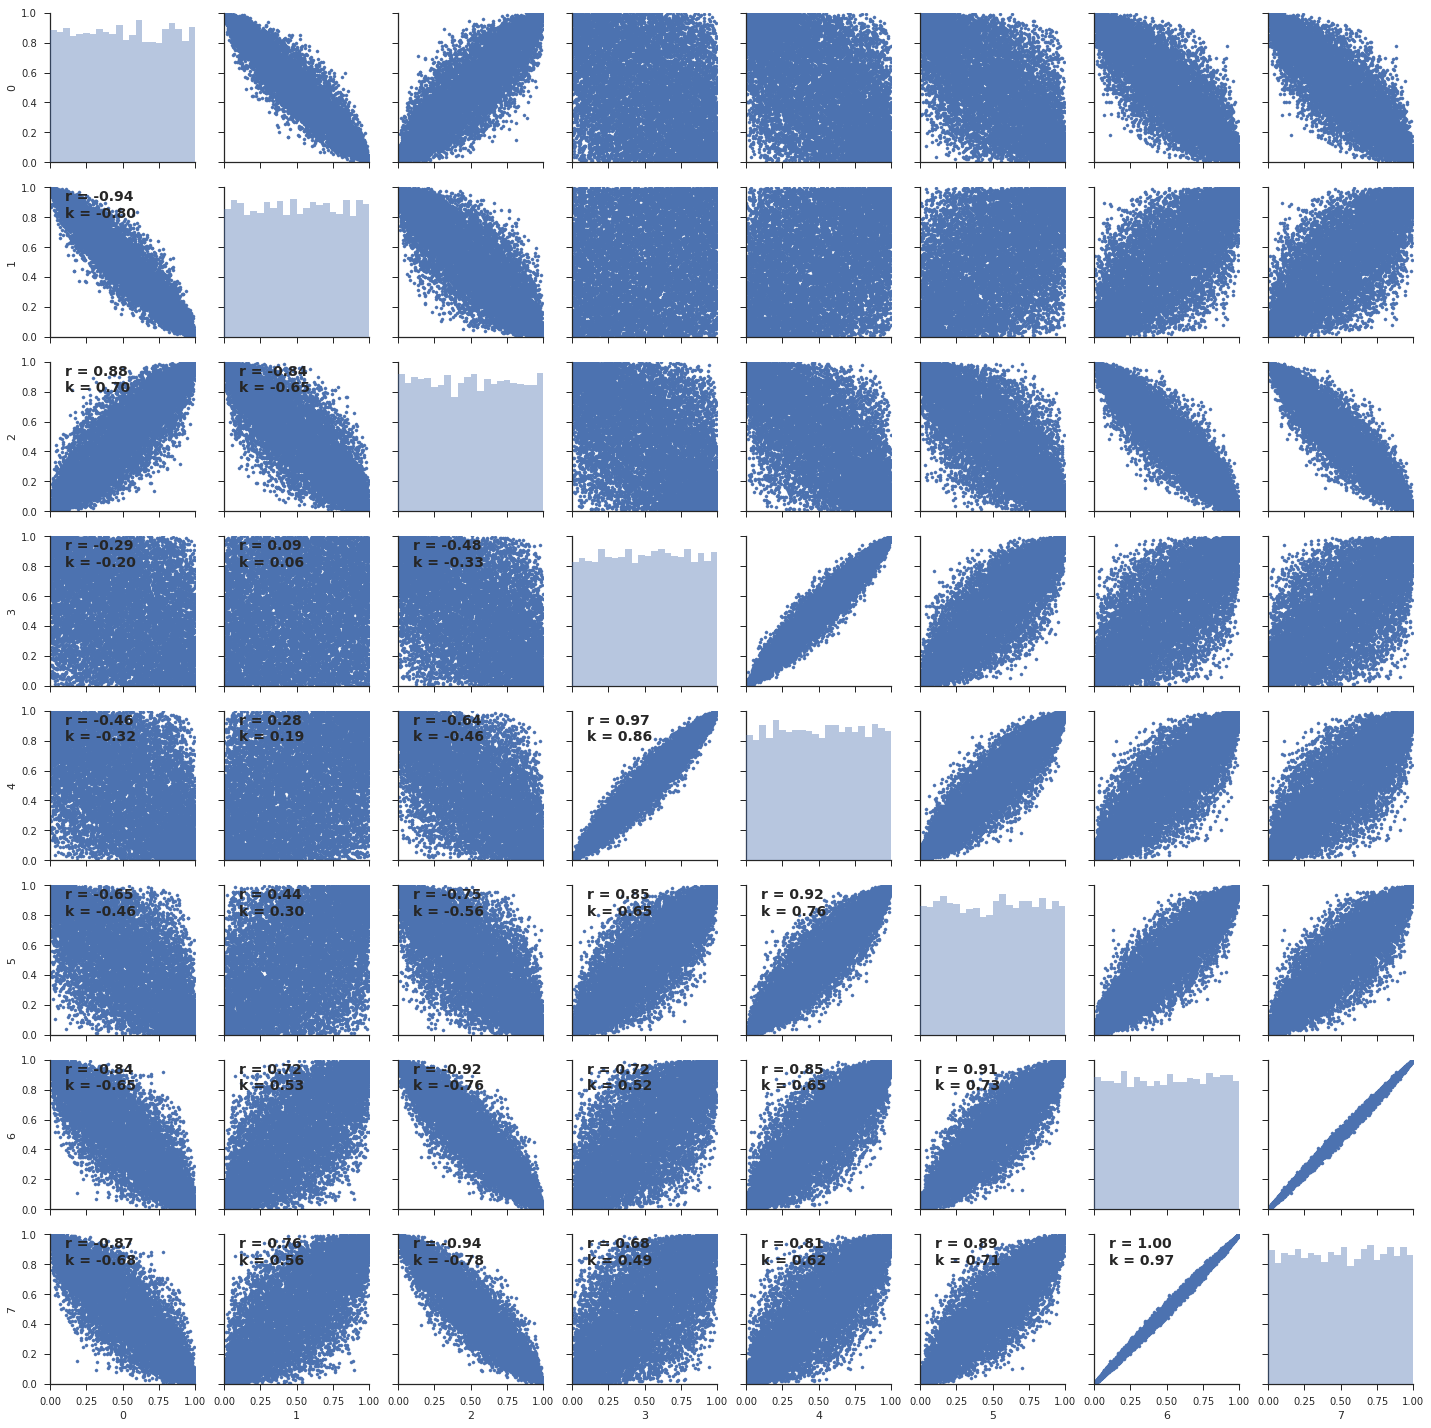

In [45]:
from dependence.dependence_plot import matrix_plot_input
matrix_plot_input(min_result, margins=margins)

In [46]:
from dependence.utils import get_pair_id, get_pairs_by_levels, get_possible_structures
pairs_iter = [[1, 0]]
pairs_iter_id = [get_pair_id(dim, pair, with_plus=False) for pair in pairs_iter]
pairs_by_levels = get_pairs_by_levels(dim, pairs_iter_id)
quant_estimate.vine_structure = get_possible_structures(dim, pairs_by_levels)[0]
quant_estimate.vine_structure

array([[2, 0, 0, 0, 0, 0, 0, 0],
       [8, 1, 0, 0, 0, 0, 0, 0],
       [7, 8, 3, 0, 0, 0, 0, 0],
       [6, 7, 8, 4, 0, 0, 0, 0],
       [5, 6, 7, 8, 5, 0, 0, 0],
       [4, 5, 6, 7, 8, 6, 0, 0],
       [3, 4, 5, 6, 7, 8, 7, 0],
       [1, 3, 4, 5, 6, 7, 8, 8]])

In [47]:
grid_results = quant_estimate.gridsearch(n_dep_param=K, n_input_sample=n, q_func=q_func)

In [48]:
min_result = grid_results.min_result
print(min_result.quantity)

-0.5385555538636204


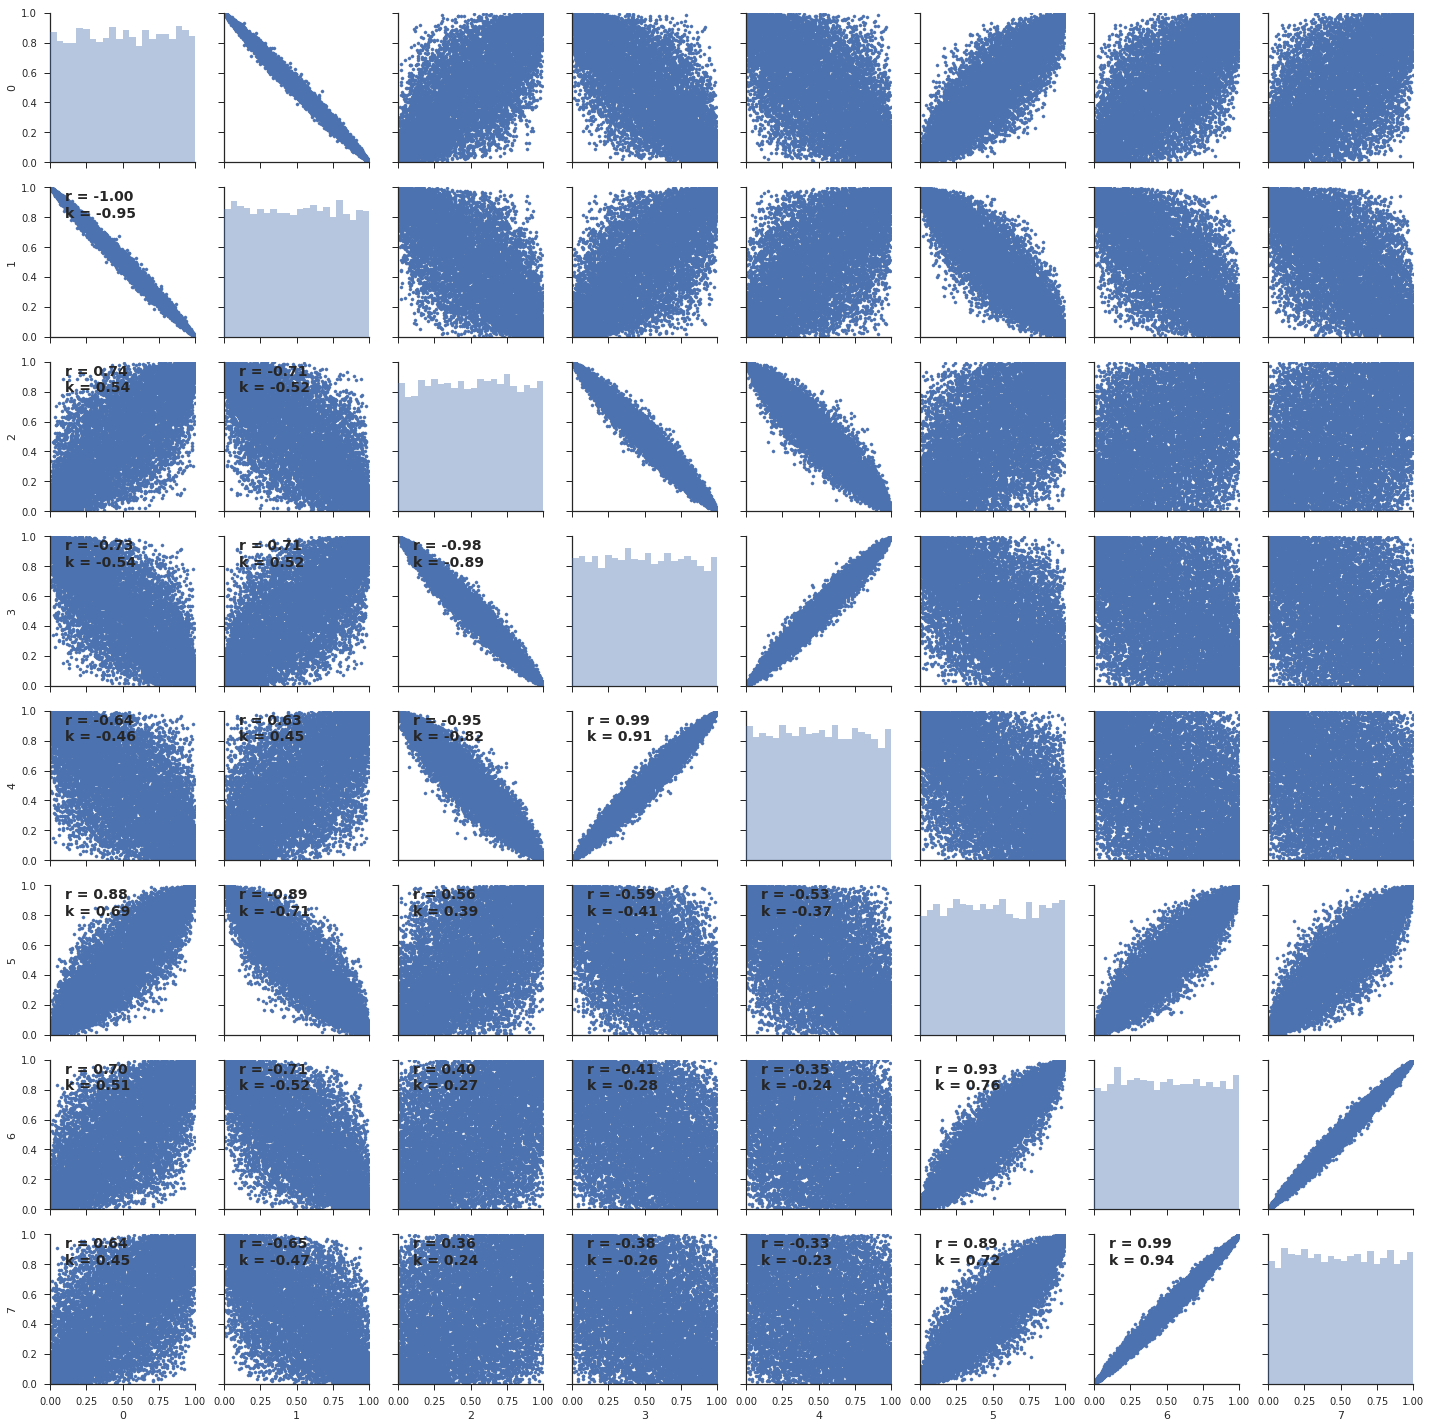

In [49]:
from dependence.dependence_plot import matrix_plot_input
matrix_plot_input(min_result, margins=margins)